In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import csv
from sklearn.impute import KNNImputer

# Introduction
Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# Define the target questions

# Data preparation

In [2]:
df_list = []
with open("HomeCredit_columns_description.csv", 'r',errors='ignore') as file:
    reader = csv.reader(file)
    for row in reader:
        df_list.append(pd.DataFrame({'table_name':row[1],'col_name':row[2],\
                                     'description':row[3]},index=list('A')))
df_description = pd.concat(df_list,axis=0).reset_index()
df_description.drop(columns='index',inplace=True)

In [3]:
def view_description_columns(table,data=df_description,column=None):
    """
    view_description_columns(table,data=df_description,column=None) designed for columns descriptions check
    :param table:
    :param data:
    :param column:
    :return: The descriptions of each column for corresponding table
    """
    if column is not None:
        return data[(data['table_name']==table)&(df_description['col_name']==column)][['col_name','description']]
    else:
        return data[data['table_name']==table][['col_name','description']]
    

## Previsous Application `prev_applic` columns description

In [4]:
# Read Previous Application table
prev_applic = pd.read_csv('previous_application.csv')

In [5]:
prev_applic.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
prev_applic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [7]:
view_description_columns(table='previous_application.csv',data=df_description)

,col_name,description
174,SK_ID_PREV,ID of previous credit in Home credit related t...
175,SK_ID_CURR,ID of loan in our sample
176,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa..."
177,AMT_ANNUITY,Annuity of previous application
178,AMT_APPLICATION,For how much credit did client ask on the prev...
179,AMT_CREDIT,Final credit amount on the previous applicatio...
180,AMT_DOWN_PAYMENT,Down payment on the previous application
181,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...
182,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...
183,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...


## Installments `installments` columns description

In [8]:
installments  = pd.read_csv('installments_payments.csv')
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [9]:
installments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [10]:
view_description_columns(table='installments_payments.csv',data=df_description)

,col_name,description
212,SK_ID_PREV,ID of previous credit in Home credit related t...
213,SK_ID_CURR,ID of loan in our sample
214,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for cred...
215,NUM_INSTALMENT_NUMBER,On which installment we observe payment
216,DAYS_INSTALMENT,When the installment of previous credit was su...
217,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...
218,AMT_INSTALMENT,What was the prescribed installment amount of ...
219,AMT_PAYMENT,What the client actually paid on previous cred...


## POS_CASH_Balance ` pos_cash_bal` column descriptions

In [11]:
pos_cash_bal = pd.read_csv('POS_CASH_balance.csv')
pos_cash_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [12]:
pos_cash_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [13]:
view_description_columns(table='POS_CASH_balance.csv',data=df_description)

,col_name,description
143,SK_ID_PREV,ID of previous credit in Home Credit related t...
144,SK_ID_CURR,ID of loan in our sample
145,MONTHS_BALANCE,Month of balance relative to application date ...
146,CNT_INSTALMENT,Term of previous credit (can change over time)
147,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit
148,NAME_CONTRACT_STATUS,Contract status during the month
149,SK_DPD,DPD (days past due) during the month of previo...
150,SK_DPD_DEF,DPD during the month with tolerance (debts wit...


## Credit card balance `credit_card_bal` columns description

In [14]:
credit_card_bal = pd.read_csv('credit_card_balance.csv')
credit_card_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [15]:
credit_card_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [16]:
view_description_columns('credit_card_balance.csv',data=df_description)

,col_name,description
151,SK_ID_PREV,ID of previous credit in Home credit related t...
152,SK_ID_CURR,ID of loan in our sample
153,MONTHS_BALANCE,Month of balance relative to application date ...
154,AMT_BALANCE,Balance during the month of previous credit
155,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the prev...
156,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the ...
157,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previou...
158,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of t...
159,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the mont...
160,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the prev...


## Bureau `bureau` columns description
- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [17]:
bureau = pd.read_csv('bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [18]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [19]:
view_description_columns('bureau.csv',data=df_description)

,col_name,description
123,SK_ID_CURR,ID of loan in our sample - one loan in our sam...
124,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit re...
125,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits
126,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit
127,DAYS_CREDIT,How many days before current application did c...
128,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the ti...
129,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at t...
130,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of appl...
131,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau cr...
132,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit pr...


## Bureau balance `bureau_applic` columns description
- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [20]:
bureau_applic = pd.read_csv('bureau_balance.csv')
bureau_applic.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [21]:
bureau_applic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [22]:
view_description_columns('bureau_balance.csv',data=df_description)

,col_name,description
140,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...
141,MONTHS_BALANCE,Month of balance relative to application date ...
142,STATUS,Status of Credit Bureau loan during the month ...


## `Application {train/test}` Columns Description

In [23]:
train_data = pd.read_csv('application_train.csv')
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [25]:
test_data = pd.read_csv('application_test.csv')

In [26]:
test_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis and Data Processing

## Data Visualizations

### bureau.csv

#### Credit type and amount of total credit distribution

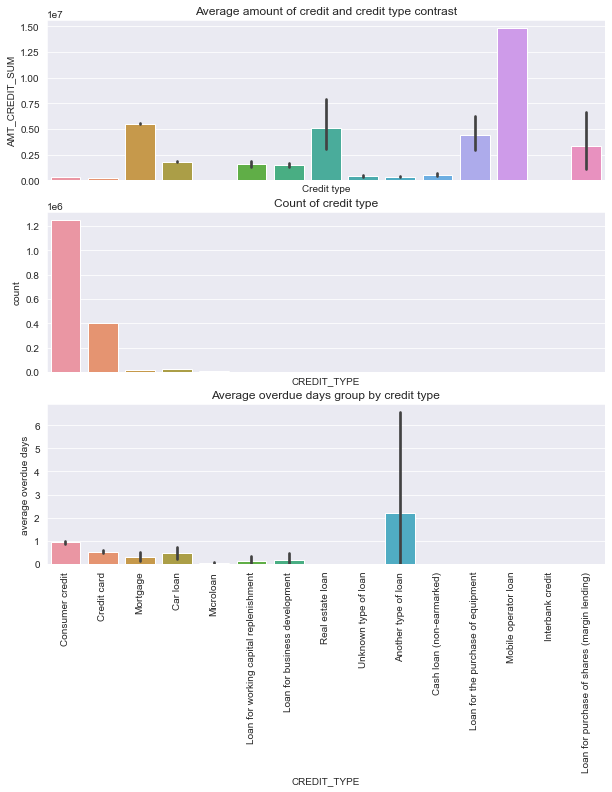

In [27]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,sharex=True,figsize= (10,10))
plt.subplot(3,1,1)
sns.barplot(data = bureau,x = 'CREDIT_TYPE',y='AMT_CREDIT_SUM',estimator=np.mean,ax = ax1)
plt.xticks(rotation = 90)
plt.xlabel('Credit type')
plt.title('Average amount of credit and credit type contrast')
plt.subplot(3,1,2)
sns.countplot(data= bureau, x='CREDIT_TYPE',ax = ax2)
plt.xticks(rotation = 90)
plt.title('Count of credit type')
plt.subplot(3,1,3)
sns.barplot(data= bureau, x = 'CREDIT_TYPE', y = 'CREDIT_DAY_OVERDUE', estimator=np.mean,ax = ax3)
plt.xticks(rotation = 90)
plt.title('Average overdue days group by credit type')
plt.ylabel('average overdue days')
plt.show()


#### Overdue Amount classified by currency

<Figure size 432x288 with 0 Axes>

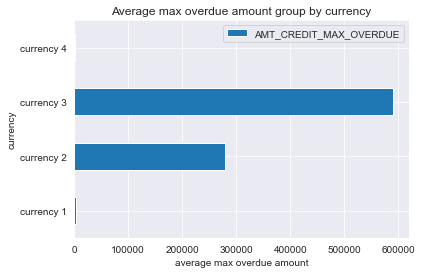

In [28]:
plt.figure()
bureau[['CREDIT_CURRENCY','AMT_CREDIT_MAX_OVERDUE']].groupby('CREDIT_CURRENCY').agg(np.mean).plot(kind='barh')
plt.xlabel('average max overdue amount')
plt.ylabel('currency')
plt.title('Average max overdue amount group by currency')
plt.show()

### previous_application,csv

#### Amount customers previously requested VS. Amount customers finally got approved

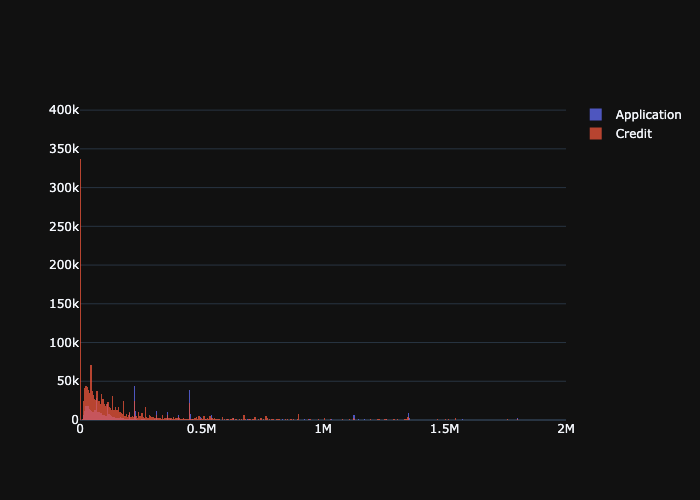

In [29]:
import plotly.graph_objects as go
x0 =prev_applic['AMT_APPLICATION']
x1 =prev_applic['AMT_CREDIT']
fig = go.Figure()
fig.add_trace(go.Histogram(x=x0,name='Application'))
fig.add_trace(go.Histogram(x=x1,name='Credit'))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity = 0.75)
fig.update_xaxes(range=[0,2000000])
fig.show('png')

#### Average goods price

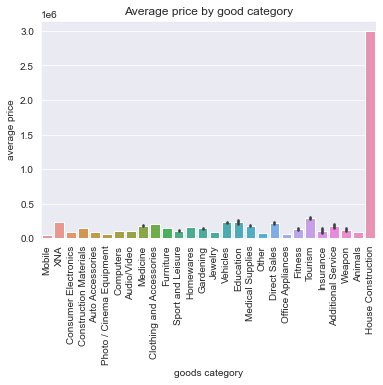

In [30]:
sns.barplot(data= prev_applic,x='NAME_GOODS_CATEGORY',y = 'AMT_APPLICATION', estimator= np.mean)
plt.xticks(rotation = 90)
plt.xlabel('goods category')
plt.ylabel('average price')
plt.title('Average price by good category')
plt.show()

### POS_CASH_balance.csv

#### Contract status and overdue days in the current month

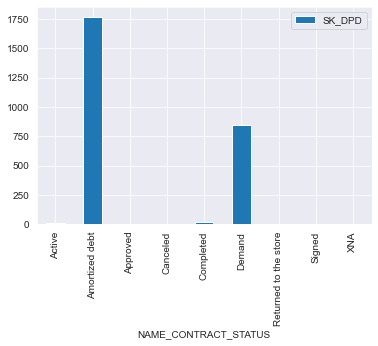

In [31]:
pos_cash_bal[['NAME_CONTRACT_STATUS','SK_DPD']].groupby('NAME_CONTRACT_STATUS').agg(np.mean).plot(kind='bar')
plt.show()

### credit_card_balance.csv

#### Overdue days of monthly payments and current amount of total payment

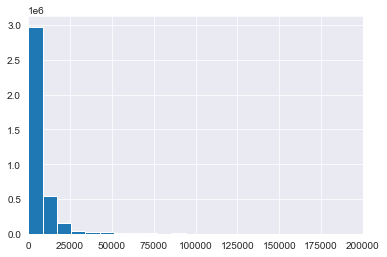

In [32]:

plt.hist(credit_card_bal['AMT_PAYMENT_TOTAL_CURRENT'],bins=500)
plt.xlim([0,200000])
plt.show()

### installments.csv

#### Amount of installments distribution

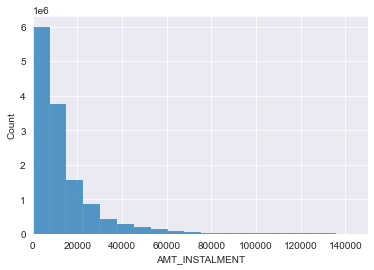

In [33]:
sns.histplot(data= installments, x='AMT_INSTALMENT', bins= 500)
plt.xlim( [0,150000])
plt.show()

### application_{train|test}.csv
Application(train/test) is the main table merging all other subservience tables.
Note:
- Some rows were dropped during the process of merging because of null values.

#### Distribution of target column in training dataset

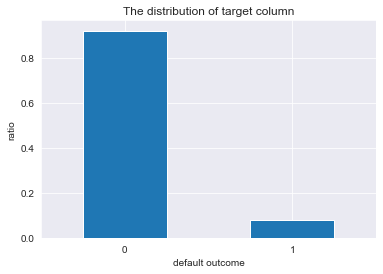

In [34]:
plt.figure()
train_data['TARGET'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('The distribution of target column')
plt.xlabel('default outcome')
plt.ylabel('ratio')
plt.xticks(rotation = 0)
plt.show()

## Missing Values Imputations for Main table

In [35]:
import missingno as mn

In [36]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [37]:
missing_value_cnt_train = missing_data(train_data)

In [38]:
missing_value_cnt_test = missing_data(test_data)

In [39]:
missing_value_cnt_test

,Total,Percent
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
NONLIVINGAPARTMENTS_AVG,33347,68.412523
NONLIVINGAPARTMENTS_MODE,33347,68.412523
...,...,...
NAME_HOUSING_TYPE,0,0.000000
NAME_FAMILY_STATUS,0,0.000000
NAME_EDUCATION_TYPE,0,0.000000
NAME_INCOME_TYPE,0,0.000000


In [40]:
total_missing_cnt = missing_value_cnt_test.merge(missing_value_cnt_train,how='inner',left_index= True, 
                             right_index=True, suffixes=['_test','_train'])

In [41]:
col_over50_missing = total_missing_cnt[(total_missing_cnt['Percent_test']>50) &
                                       (total_missing_cnt['Percent_train']>50)]

In [42]:
total_missing_cnt['diff'] = total_missing_cnt['Percent_test'] - total_missing_cnt['Percent_train']

In [43]:
col_without_null = total_missing_cnt[(total_missing_cnt['Total_test'] == 0) 
                                     &(total_missing_cnt['Total_train'] == 0)].index

In [44]:
col_with_null = total_missing_cnt.index.difference(col_without_null)

In [45]:
col_with_null.shape

(67,)

In [46]:
col_over50_missing.index.shape

(29,)

In [47]:
col_without_null.shape

(54,)

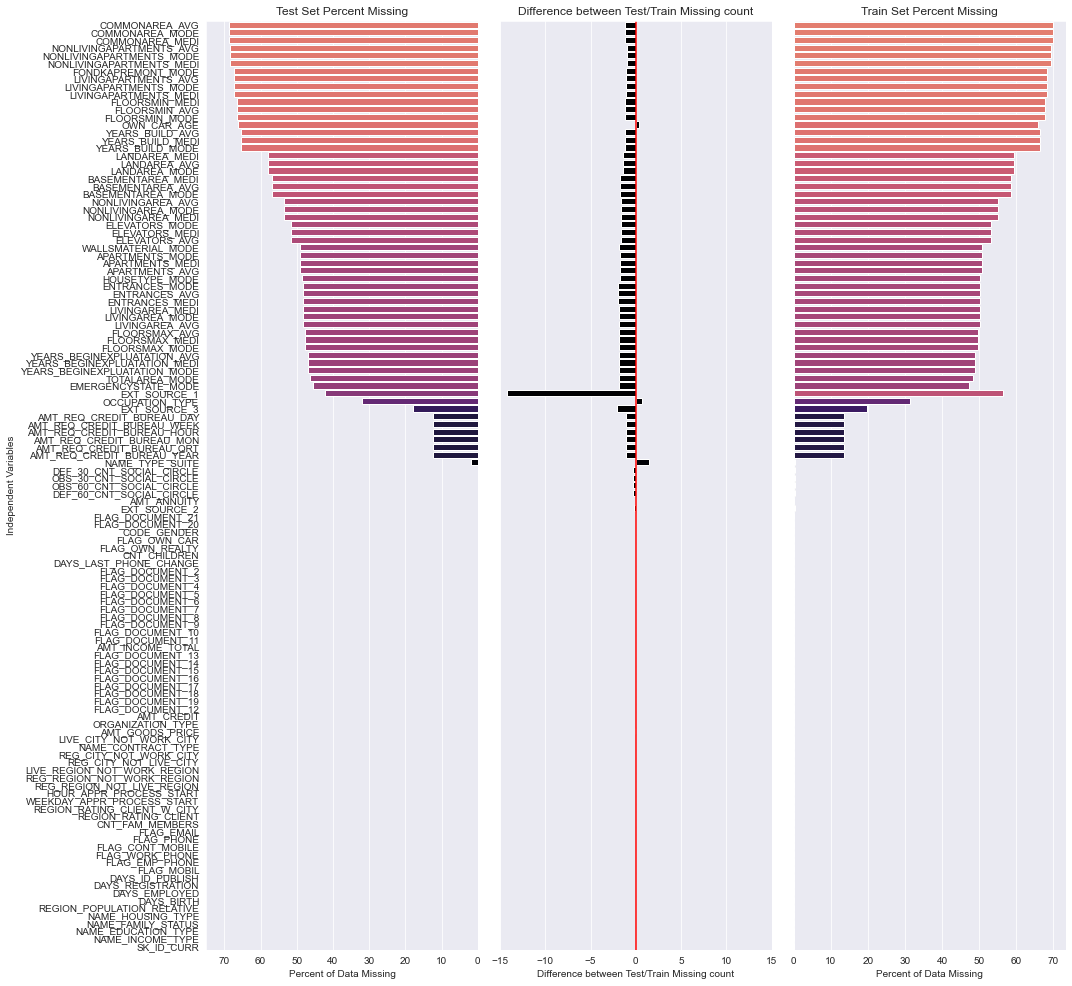

In [48]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,15), sharey=True)
ax1 = sns.barplot(y = total_missing_cnt.index, x ='Percent_test', data=total_missing_cnt,ax=ax1,
                  palette=plt.cm.magma(total_missing_cnt['Percent_test']*.01))
ax1.set_xlim(75,0)
ax1.set_xlabel('Percent of Data Missing')
ax1.set_title('Test Set Percent Missing')
ax1.set_ylabel('Independent Variables')

ax2 = sns.barplot(y = total_missing_cnt.index, x ="diff", data=total_missing_cnt,ax=ax2,
                  palette=plt.cm.magma(total_missing_cnt['diff']*.01))
ax2.set_xlabel('Difference between Test/Train Missing count')
ax2.set_title('Difference between Test/Train Missing count')
ax2.set_xlim(-15,15)
ax2.axvline(x=0, c = "r")
ax2.set_ylabel('')

ax3 = sns.barplot(y = total_missing_cnt.index, x ="Percent_train", data=total_missing_cnt,ax=ax3,
                  palette=plt.cm.magma(total_missing_cnt['Percent_train']*.01))
ax3.set_xlabel('Percent of Data Missing')
ax3.set_title('Train Set Percent Missing')
ax3.set_ylabel('')

f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


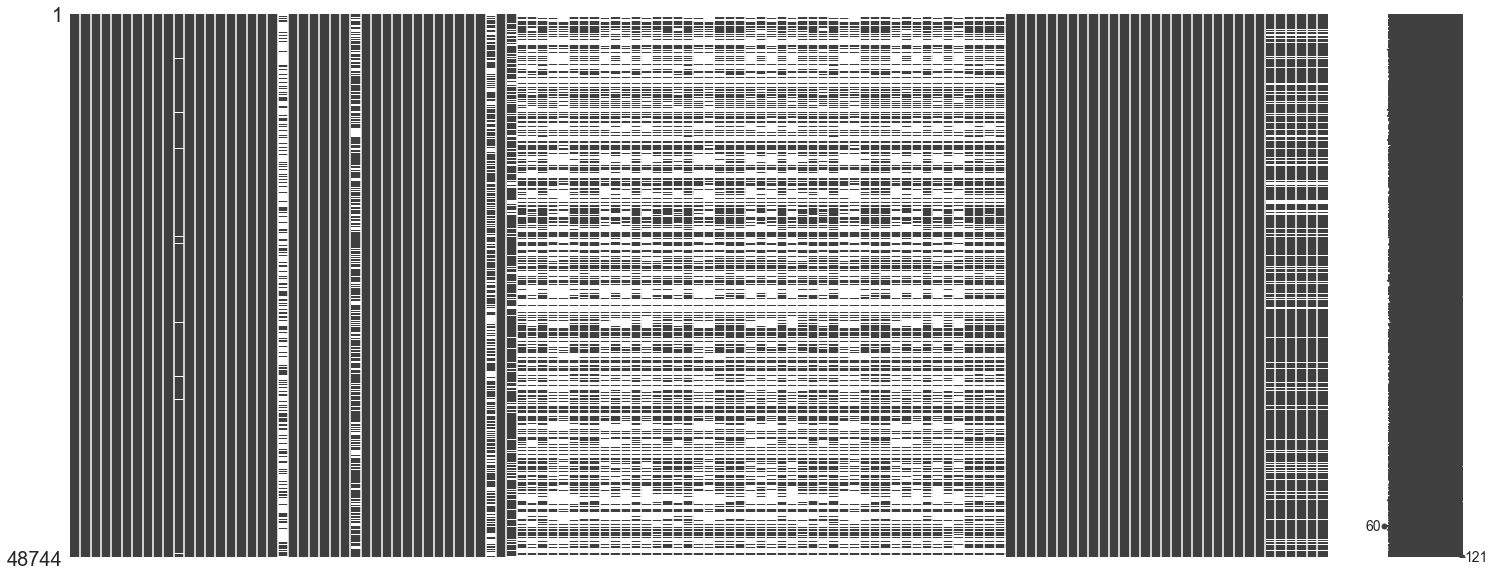

In [49]:
mn.matrix(test_data)
plt.show()

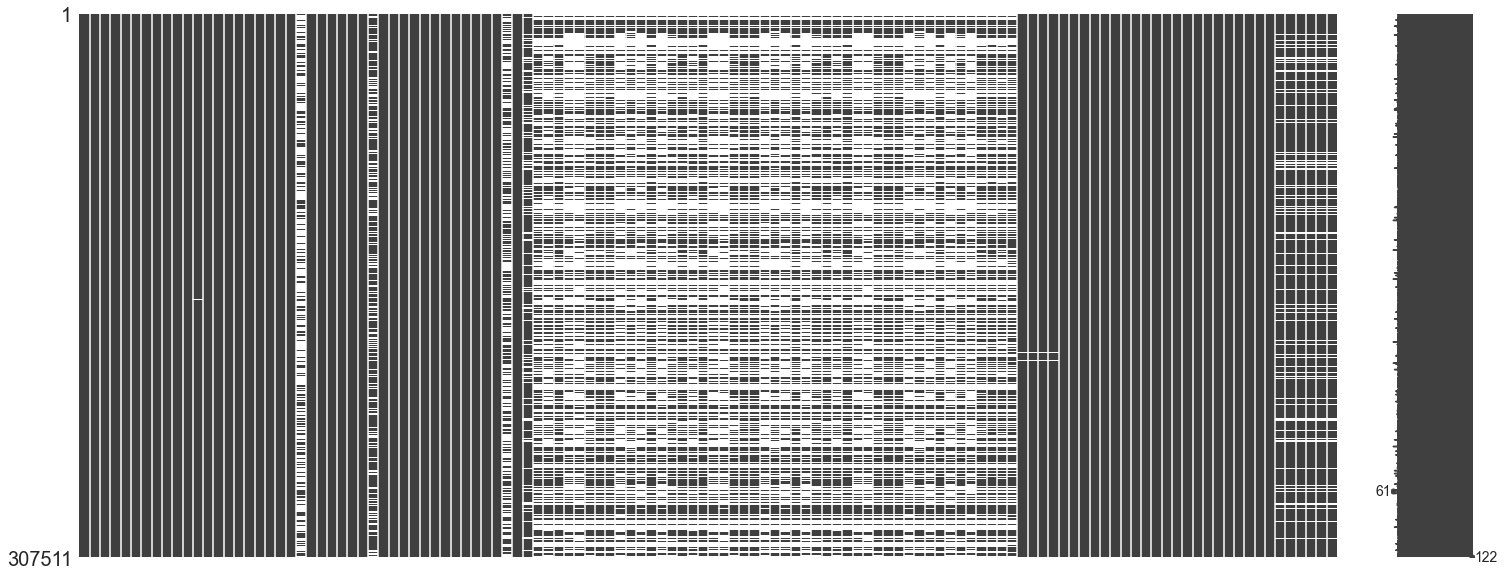

In [50]:
mn.matrix(train_data)
plt.show()

In [51]:
from sklearn.impute import SimpleImputer

### Missing Values Imputation for Train Dataset

In [52]:
col_with_null_cat_train = train_data[col_with_null].select_dtypes(include = 'object').columns

In [53]:
col_with_null_num_train = col_with_null.difference(col_with_null_cat_train)

In [54]:
train_data[col_with_null_num_train].isnull().sum()

AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
AMT_REQ_CREDIT_BUREAU_DAY        41519
AMT_REQ_CREDIT_BUREAU_HOUR       41519
AMT_REQ_CREDIT_BUREAU_MON        41519
                                 ...  
YEARS_BEGINEXPLUATATION_MEDI    150007
YEARS_BEGINEXPLUATATION_MODE    150007
YEARS_BUILD_AVG                 204488
YEARS_BUILD_MEDI                204488
YEARS_BUILD_MODE                204488
Length: 61, dtype: int64

In [55]:
missing_imputer_num = SimpleImputer(strategy= 'mean',missing_values=np.nan)
train_data[col_with_null_num_train] = missing_imputer_num.fit_transform(train_data[col_with_null_num_train])

In [56]:
train_data[col_with_null_num_train].isnull().sum().sum()

0

In [57]:
train_data[col_with_null_cat_train].isnull().sum()/train_data[col_with_null_cat_train].shape[0]

EMERGENCYSTATE_MODE    0.473983
FONDKAPREMONT_MODE     0.683862
HOUSETYPE_MODE         0.501761
NAME_TYPE_SUITE        0.004201
OCCUPATION_TYPE        0.313455
WALLSMATERIAL_MODE     0.508408
dtype: float64

In [58]:
missing_imputer_cat = SimpleImputer(strategy= 'most_frequent',missing_values=np.nan)
train_data[col_with_null_cat_train] = missing_imputer_cat.fit_transform(train_data[col_with_null_cat_train])

In [59]:
train_data[col_with_null_cat_train].isnull().sum()

EMERGENCYSTATE_MODE    0
FONDKAPREMONT_MODE     0
HOUSETYPE_MODE         0
NAME_TYPE_SUITE        0
OCCUPATION_TYPE        0
WALLSMATERIAL_MODE     0
dtype: int64

### Missing Values Imputation for Test Dataset


In [60]:
col_with_null_cat_test = test_data[col_with_null].select_dtypes(include = 'object').columns

In [61]:
col_with_null_num_test = col_with_null.difference(col_with_null_cat_test)

In [62]:
test_data[col_with_null_num_test].isnull().sum()

AMT_ANNUITY                        24
AMT_GOODS_PRICE                     0
AMT_REQ_CREDIT_BUREAU_DAY        6049
AMT_REQ_CREDIT_BUREAU_HOUR       6049
AMT_REQ_CREDIT_BUREAU_MON        6049
                                ...  
YEARS_BEGINEXPLUATATION_MEDI    22856
YEARS_BEGINEXPLUATATION_MODE    22856
YEARS_BUILD_AVG                 31818
YEARS_BUILD_MEDI                31818
YEARS_BUILD_MODE                31818
Length: 61, dtype: int64

In [63]:
missing_imputer_num = SimpleImputer(strategy= 'mean',missing_values=np.nan)
test_data[col_with_null_num_test] = missing_imputer_num.fit_transform(test_data[col_with_null_num_test])

In [64]:
missing_imputer_cat = SimpleImputer(strategy= 'most_frequent',missing_values=np.nan)
test_data[col_with_null_cat_test] = missing_imputer_cat.fit_transform(test_data[col_with_null_cat_test])

In [65]:
test_data.isnull().sum().sum()

0

## Duplication Check

In [66]:
train_duplicate = train_data.duplicated()
train_data[train_duplicate].shape[0]

0

# Feature Engineering

## Encoding Categorical Columns

### Label Encoding

In [67]:
cat_col = train_data.select_dtypes(include='object').columns

In [68]:
for i in cat_col:
    print(f'The column of {i} has unique values \n {train_data[i].unique()}\n\n')

The column of NAME_CONTRACT_TYPE has unique values 
 ['Cash loans' 'Revolving loans']


The column of CODE_GENDER has unique values 
 ['M' 'F' 'XNA']


The column of FLAG_OWN_CAR has unique values 
 ['N' 'Y']


The column of FLAG_OWN_REALTY has unique values 
 ['Y' 'N']


The column of NAME_TYPE_SUITE has unique values 
 ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' 'Other_B'
 'Group of people']


The column of NAME_INCOME_TYPE has unique values 
 ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']


The column of NAME_EDUCATION_TYPE has unique values 
 ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


The column of NAME_FAMILY_STATUS has unique values 
 ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']


The column of NAME_HOUSING_TYPE has unique values 
 ['House / apartment' 'Rented apartment' 'With parent

In [69]:
label_encode_col = ['WEEKDAY_APPR_PROCESS_START','NAME_EDUCATION_TYPE']

In [70]:
mapping_weekday = {'MONDAY':1,'TUESDAY':2,'WEDNESDAY':3,'THURSDAY':4,'FRIDAY':5,'SATURDAY':0,'SUNDAY':6}
mapping_education = {'Lower secondary':0,'Secondary / secondary special':1,'Incomplete higher':2,'Higher education':3,'Academic degree':4}

In [71]:
train_data['WEEKDAY_APPR_PROCESS_START_label'] = train_data['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)
train_data['NAME_EDUCATION_TYPE_label'] = train_data['NAME_EDUCATION_TYPE'].map(mapping_education)


In [72]:
test_data['WEEKDAY_APPR_PROCESS_START_label'] = test_data['WEEKDAY_APPR_PROCESS_START'].map(mapping_weekday)
test_data['NAME_EDUCATION_TYPE_label'] = test_data['NAME_EDUCATION_TYPE'].map(mapping_education)

In [73]:
onehot_encode_ = list(cat_col.difference(label_encode_col))
onehot_encode_

['CODE_GENDER',
 'EMERGENCYSTATE_MODE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'NAME_CONTRACT_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'NAME_INCOME_TYPE',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'WALLSMATERIAL_MODE']

### One-hot Encoding

In [74]:
from sklearn.preprocessing import OneHotEncoder
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

In [75]:
for col in onehot_encode_:
    subcategory = pd.DataFrame(train_data[col])
    encoded = ohe.fit_transform(subcategory)
    dense_array = encoded.toarray()
    # Put into a dataframe to get column names
    encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
    train_data = pd.concat((train_data,encoded_df),axis='columns')

In [76]:
for col in onehot_encode_:
    subcategory = pd.DataFrame(test_data[col])
    encoded = ohe.fit_transform(subcategory)
    dense_array = encoded.toarray()
    # Put into a dataframe to get column names
    encoded_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)
    test_data = pd.concat((test_data,encoded_df),axis='columns')

In [77]:
clean_train_df = train_data.drop(columns =cat_col)

clean_test_df = test_data.drop(columns = cat_col)



In [78]:
clean_test_df.shape == clean_train_df.shape

False

In [79]:
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

In [80]:
Diff(clean_test_df,clean_train_df)

[('Unknown',), 'TARGET', ('Maternity leave',)]

In [81]:
clean_test_df.shape[0]

48744

In [82]:
d = {('Maternity leave',):[0]*(clean_test_df.shape[0]),('Unknown',):[0]*clean_test_df.shape[0]}
df = pd.DataFrame(data=d)
clean_test_df = pd.concat((clean_test_df,df),axis='columns')


In [83]:
Diff(clean_test_df,clean_train_df)

['TARGET']

# Modeling

## Feature Selection

### Remove Multicolinearity

In [84]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = clean_train_df.corr().abs()
corr_matrix.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,"(Transport: type 4,)","(University,)","(XNA,)","(Block,)","(Mixed,)","(Monolithic,)","(Others,)","(Panel,)","(Stone, brick,)","(Wooden,)"
SK_ID_CURR,1.000000,0.002108,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,...,0.002658,0.000496,0.001368,0.002073,0.000976,0.000072,0.001396,0.000857,0.001281,0.000270
TARGET,0.002108,1.000000,0.019187,0.003982,0.030369,0.012817,0.039628,0.037227,0.078239,0.044932,...,0.005929,0.007672,0.045987,0.006777,0.001713,0.009384,0.000628,0.013618,0.012657,0.007946
CNT_CHILDREN,0.001129,0.019187,1.000000,0.012882,0.002145,0.021374,0.001826,0.025573,0.330938,0.239818,...,0.011959,0.000854,0.240722,0.005272,0.000709,0.001607,0.002032,0.021847,0.025088,0.011036
AMT_INCOME_TOTAL,0.001820,0.003982,0.012882,1.000000,0.156870,0.191657,0.159600,0.074796,0.027261,0.064223,...,0.012323,0.005098,0.064038,0.011696,0.006149,0.023886,0.003886,0.024403,0.016523,0.003369
AMT_CREDIT,0.000343,0.030369,0.002145,0.156870,1.000000,0.770127,0.986588,0.099738,0.055436,0.066838,...,0.012154,0.017552,0.065594,0.014314,0.007987,0.027255,0.005799,0.019298,0.009756,0.007373


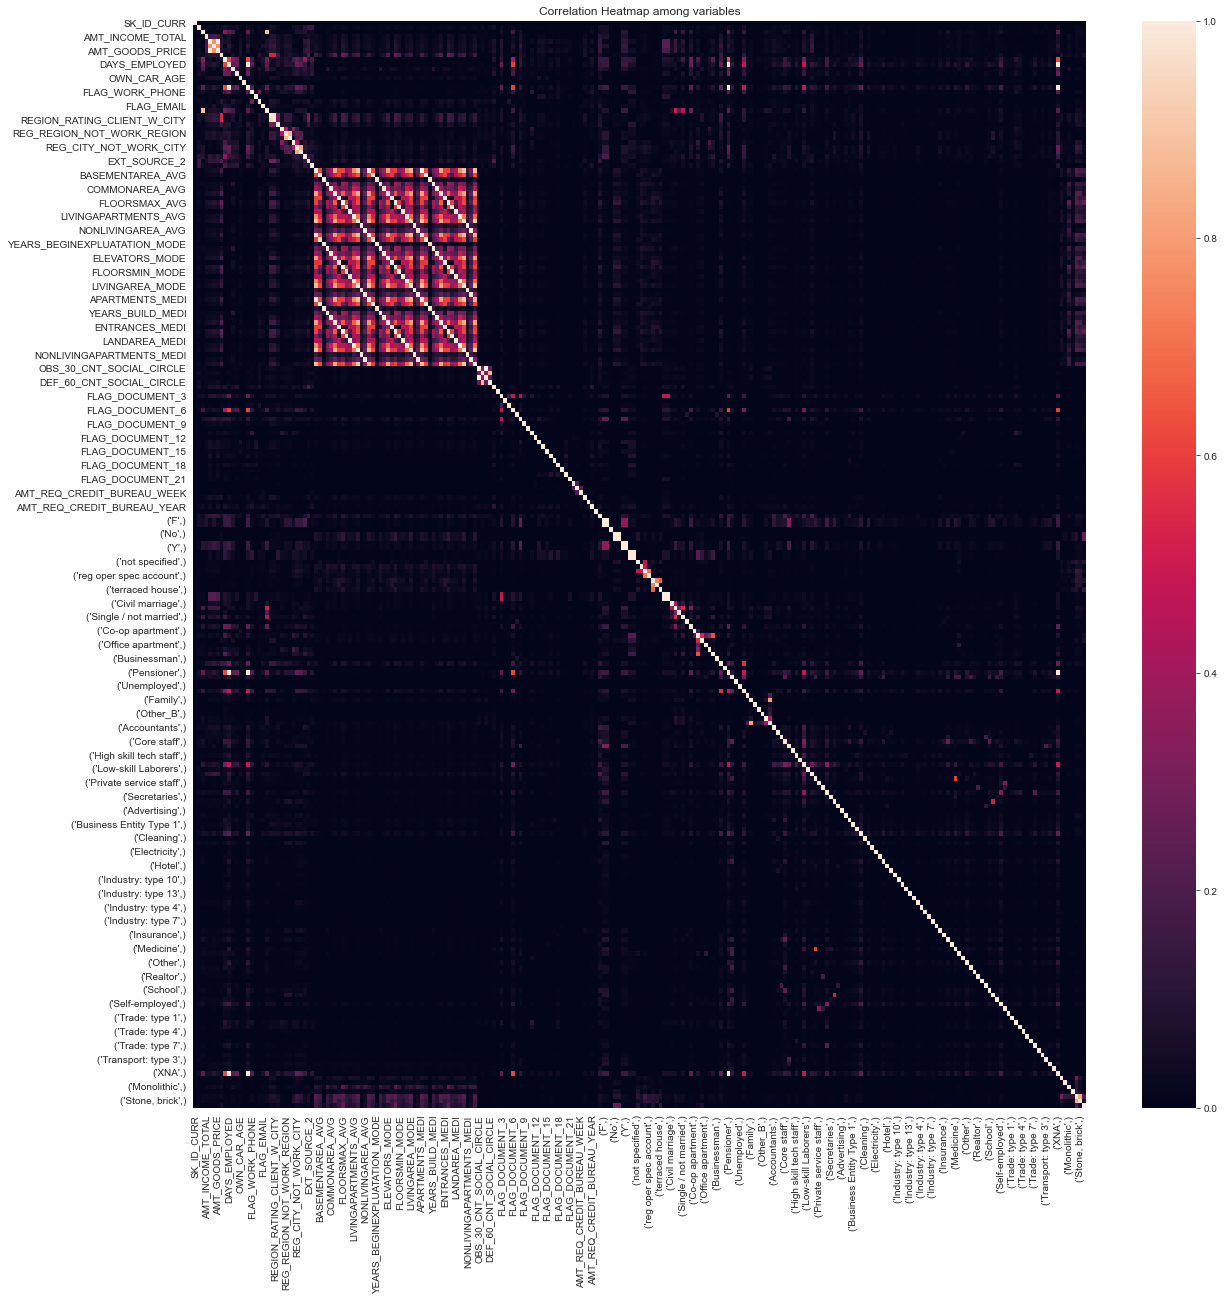

In [85]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix)
plt.title('Correlation Heatmap among variables')
plt.show()

In [86]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

/var/folders/xy/406yv2ts4sqg09841vwh_phm0000gn/T/ipykernel_22984/1832695365.py:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,"(Transport: type 4,)","(University,)","(XNA,)","(Block,)","(Mixed,)","(Monolithic,)","(Others,)","(Panel,)","(Stone, brick,)","(Wooden,)"
SK_ID_CURR,NaN,0.002108,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,...,0.002658,0.000496,0.001368,0.002073,0.000976,0.000072,0.001396,0.000857,0.001281,0.000270
TARGET,NaN,NaN,0.019187,0.003982,0.030369,0.012817,0.039628,0.037227,0.078239,0.044932,...,0.005929,0.007672,0.045987,0.006777,0.001713,0.009384,0.000628,0.013618,0.012657,0.007946
CNT_CHILDREN,NaN,NaN,NaN,0.012882,0.002145,0.021374,0.001826,0.025573,0.330938,0.239818,...,0.011959,0.000854,0.240722,0.005272,0.000709,0.001607,0.002032,0.021847,0.025088,0.011036
AMT_INCOME_TOTAL,NaN,NaN,NaN,NaN,0.156870,0.191657,0.159600,0.074796,0.027261,0.064223,...,0.012323,0.005098,0.064038,0.011696,0.006149,0.023886,0.003886,0.024403,0.016523,0.003369
AMT_CREDIT,NaN,NaN,NaN,NaN,NaN,0.770127,0.986588,0.099738,0.055436,0.066838,...,0.012154,0.017552,0.065594,0.014314,0.007987,0.027255,0.005799,0.019298,0.009756,0.007373


In [87]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 51 columns to remove.


In [88]:
clean_train_df = clean_train_df.drop(columns = to_drop,axis='columns')
clean_test_df = clean_test_df.drop(columns = to_drop,axis='columns')

print('Training shape: ', clean_train_df.shape)
print('Testing shape: ', clean_test_df.shape)

/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Training shape:  (307511, 185)
Testing shape:  (48744, 184)


## Base Model

In [89]:
## Scaling
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train = clean_train_df.drop('TARGET',axis='columns')
y_train = clean_train_df['TARGET']
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled =  min_max_scaler.fit_transform(clean_test_df)

/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.

/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.

/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.

/Users/yuegao/opt/anaconda3/envs/capstone_proj/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['s

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [97]:
logreg = LogisticRegression(solver = 'liblinear')
params = {'C':[0.01,0.1,1,10,100]}
grid_search = GridSearchCV(estimator=logreg,param_grid=params,n_jobs=-1,cv=10)
grid_search.fit(X_train_scaled,y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'grid_result' is not defined

In [98]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.919255 using {'C': 0.1}
0.919206 (0.000075) with: {'C': 0.01}
0.919255 (0.000175) with: {'C': 0.1}
0.919232 (0.000149) with: {'C': 1}
0.919219 (0.000122) with: {'C': 10}
0.919229 (0.000114) with: {'C': 100}


In [100]:
logreg = LogisticRegression(C=0.1,solver= 'liblinear')
logreg.fit(X_train_scaled,y_train)
prediction = logreg.predict(X_test_scaled)

## Ensemble Model

In [103]:
prediction.shape

(48744,)

In [105]:
submit = pd.read_csv('/Users/yuegao/ML_Projects/capstone/workplace/sample_submission.csv')
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


In [106]:
submit['TARGET'] = prediction
submit.head()

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0


In [107]:
submit.to_csv('log_reg_baseline.csv', index = False)